# **0. Setup**

## 0.1. Library and Environment

In [9]:
# !pip -U install pandas matplotlib yfinance seaborn plotly alpha_vantage python-dotenv nbformat statsmodels scikit-learn

In [10]:
import os
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.ensemble import IsolationForest
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats

np.random.seed(42)
pd.set_option("display.max_columns", None)

FIG_DIR = "fig"

## 0.2. Data downloading

In [11]:
data = pd.read_csv("data/v5.csv", index_col=0)

# **1. EDA**

## a. Data Summary

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3518 entries, 0 to 3517
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         3518 non-null   object 
 1   Open         3518 non-null   float64
 2   High         3518 non-null   float64
 3   Low          3518 non-null   float64
 4   Close        3518 non-null   float64
 5   Volume       3518 non-null   int64  
 6   VIX          3518 non-null   float64
 7   US10Y        3518 non-null   float64
 8   DXY          3518 non-null   float64
 9   OIL          3518 non-null   float64
 10  GOLD         3518 non-null   float64
 11  CPI_US       3518 non-null   float64
 12  MA_20        3518 non-null   float64
 13  EMA_20       3518 non-null   float64
 14  MAE_20       3518 non-null   float64
 15  MA_60        3518 non-null   float64
 16  EMA_60       3518 non-null   float64
 17  MAE_60       3518 non-null   float64
 18  MA_120       3518 non-null   float64
 19  EMA_120    

In [13]:
print(f"Null value check: \n{data.isna().sum()}")

Null value check: 
Date           0
Open           0
High           0
Low            0
Close          0
Volume         0
VIX            0
US10Y          0
DXY            0
OIL            0
GOLD           0
CPI_US         0
MA_20          0
EMA_20         0
MAE_20         0
MA_60          0
EMA_60         0
MAE_60         0
MA_120         0
EMA_120        0
MAE_120        0
MA_360         0
EMA_360        0
MAE_360        0
MACD           0
MACD_long      0
Signal         0
Signal_long    0
RSI_7          0
RSI_14         0
RSI_28         0
RSI_56         0
dtype: int64


In [14]:
duplicate_count = data.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")

Duplicate rows: 0


## b. Statistical Analysis

In [15]:
def statistical_analysis(df: pd.DataFrame) -> dict:
    result = {
        "mean": df.mean(),
        "median": df.median(),
        "std": df.std(),
        "min": df.min(),
        "max": df.max(),
        "q1": df.quantile(0.25),
        "q3": df.quantile(0.75),
        "iqr": df.quantile(0.75) - df.quantile(0.25)
    }

    return result

stats_summary = pd.DataFrame({
    col: statistical_analysis(data[col])
    for col in data.select_dtypes(include=['number']).columns
})
stats_summary

,Open,High,Low,Close,Volume,VIX,US10Y,DXY,OIL,GOLD,CPI_US,MA_20,EMA_20,MAE_20,MA_60,EMA_60,MAE_60,MA_120,EMA_120,MAE_120,MA_360,EMA_360,MAE_360,MACD,MACD_long,Signal,Signal_long,RSI_7,RSI_14,RSI_28,RSI_56
mean,416.459915,419.610855,413.316316,416.580211,1.197605e+08,25.289144,105.360025,25.017769,35.072762,148.542763,26.580698,414.966987,414.952079,3.721269,411.458288,411.563439,3.700360,406.576574,406.889095,3.669890,389.969796,391.248799,3.604618,1.215616,4.674345,1.221636,4.497438,54.519207,54.383979,54.048229,53.565418
median,406.690002,410.020004,403.309998,406.745010,4.748800e+06,20.470000,105.330000,25.060000,33.615000,143.880000,26.592500,405.914249,406.050263,3.040243,403.902667,404.316265,3.134418,401.433917,406.148377,3.198917,391.161042,397.452659,2.793834,1.486598,4.074653,1.466118,4.068069,54.871884,54.428400,54.347001,53.651690
std,156.521521,157.565916,155.479851,156.526060,1.629818e+08,17.136061,7.295446,2.383741,22.894994,31.642322,0.872154,155.198624,155.028135,2.481358,152.335559,152.175074,2.126325,148.997245,148.740057,1.911879,139.863559,140.068571,1.657025,6.036312,11.229062,5.651588,10.349887,22.755735,16.284104,11.289183,7.806017
min,151.729996,158.000000,147.660004,153.899994,0.000000e+00,5.250000,88.950000,20.930000,2.130000,100.500000,23.919900,162.902000,163.194174,0.619501,169.174833,172.083540,1.231834,172.688666,177.768672,1.410250,192.139167,191.193539,1.675583,-47.619195,-31.174432,-41.028616,-25.386829,0.000000,2.186875,21.404229,29.465601
max,854.250000,857.109985,851.289978,851.979980,1.335046e+09,121.950000,123.060000,30.670000,91.990000,257.500000,28.520000,835.313501,830.505641,24.299998,806.952665,802.998564,14.902166,769.021499,774.446570,10.773832,674.711943,698.742249,7.110110,18.004074,36.935660,16.728409,34.841029,100.000000,96.628614,85.733906,76.278294
q1,297.874992,299.687508,295.830002,297.967506,0.000000e+00,14.050000,101.270000,22.710000,12.740000,121.332500,25.890000,297.001375,296.699491,2.053999,295.947127,296.945605,2.084501,296.267418,296.460104,2.170229,276.167223,275.184642,2.399632,-1.243367,-0.311478,-0.960669,-0.745924,37.601945,43.065670,46.147471,48.649747
q3,537.517517,543.132507,533.512482,537.649994,2.544945e+08,29.545000,109.300000,26.470000,47.795000,169.505000,27.344850,539.542501,540.549710,4.767378,546.192373,546.998772,4.892749,548.107376,552.929139,4.807166,468.332764,505.664467,5.228770,4.166297,9.681235,3.857002,9.171006,71.842171,66.224710,62.215228,58.705930
iqr,239.642525,243.445000,237.682480,239.682487,2.544945e+08,15.495000,8.030000,3.760000,35.055000,48.172500,1.454850,242.541126,243.850219,2.713379,250.245247,250.053167,2.808249,251.839958,256.469035,2.636937,192.165542,230.479825,2.829137,5.409664,9.992713,4.817672,9.916930,34.240226,23.159041,16.067757,10.056184


## c. Visualization

### c.1. Candlestick Chart

In [16]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Candlestick(
        x=data['Date'],
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='Price'
    ),
    secondary_y=True
)

fig.add_trace(
    go.Bar(
        x=data['Date'],
        y=data['Volume'],
        name='Volume',
        marker_color='blue',
        opacity=0.4
    ),
    secondary_y=False
)

fig.update_yaxes(showgrid=False, secondary_y=True)
fig.update_layout(
    title='S&P 500 Financials (Sector) (^SP500-40)',
    xaxis_title='Date',
    yaxis_title='Volume',
    yaxis2_title='Index',
    xaxis_rangeslider_visible=False,
    template='seaborn',
    width=2000,
    height=600,
)

fig.show()

### c.2. Boxplot

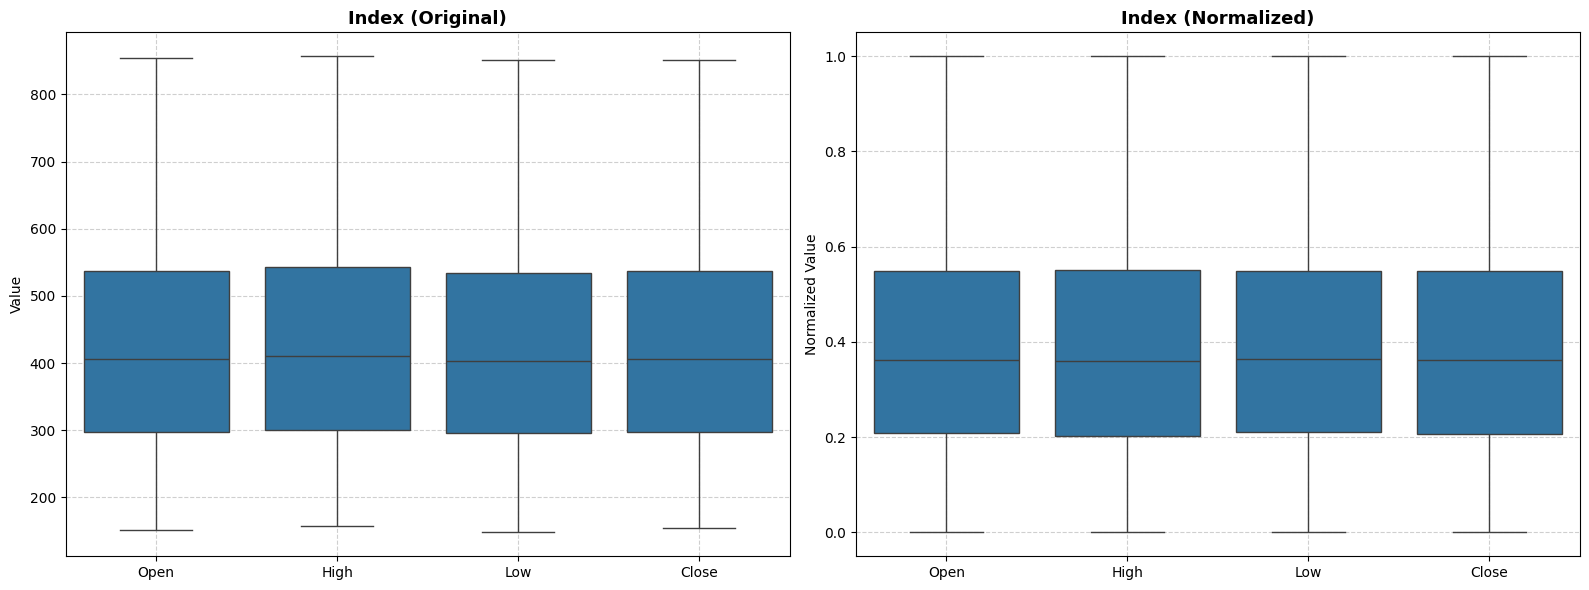

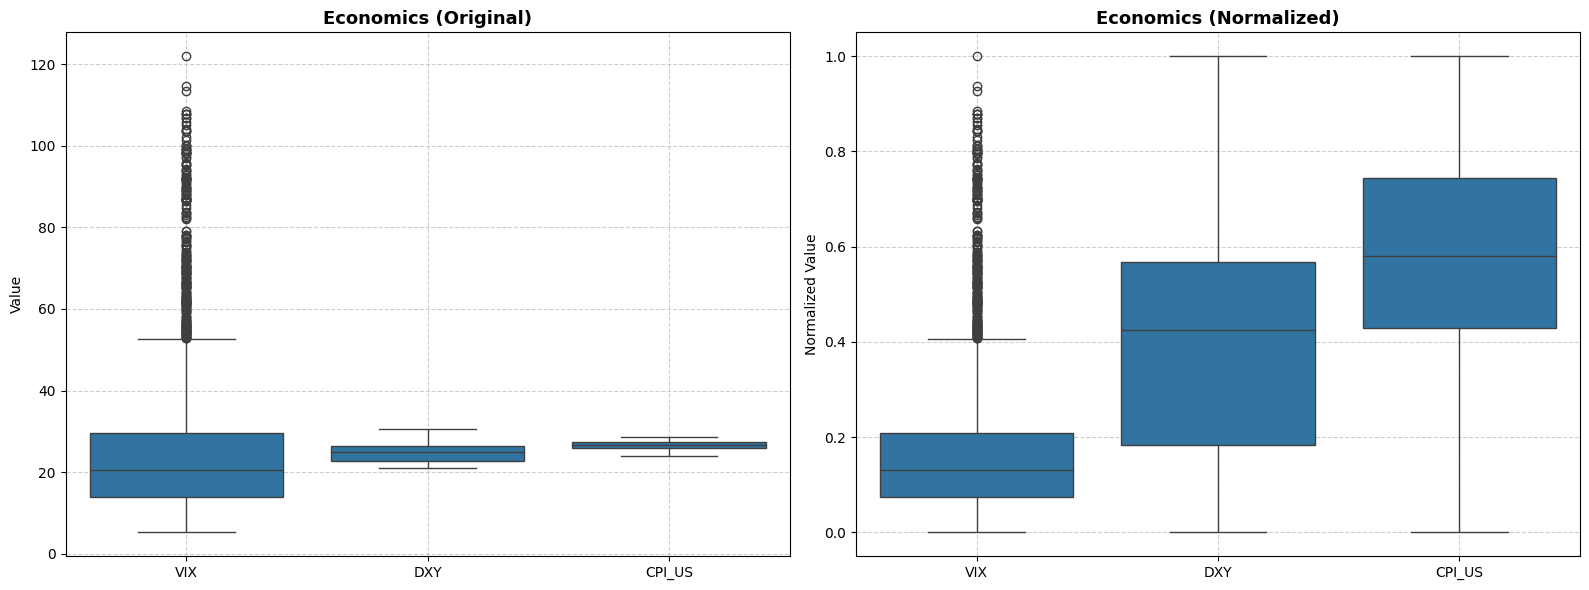

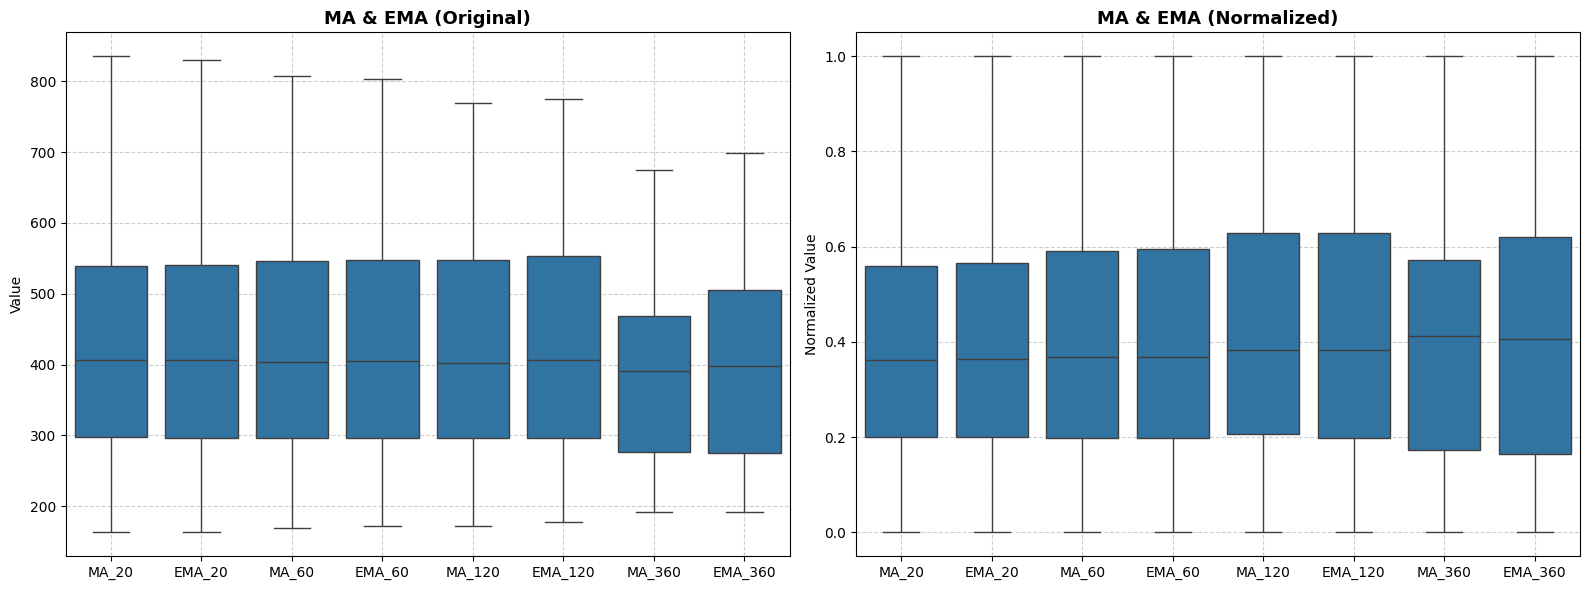

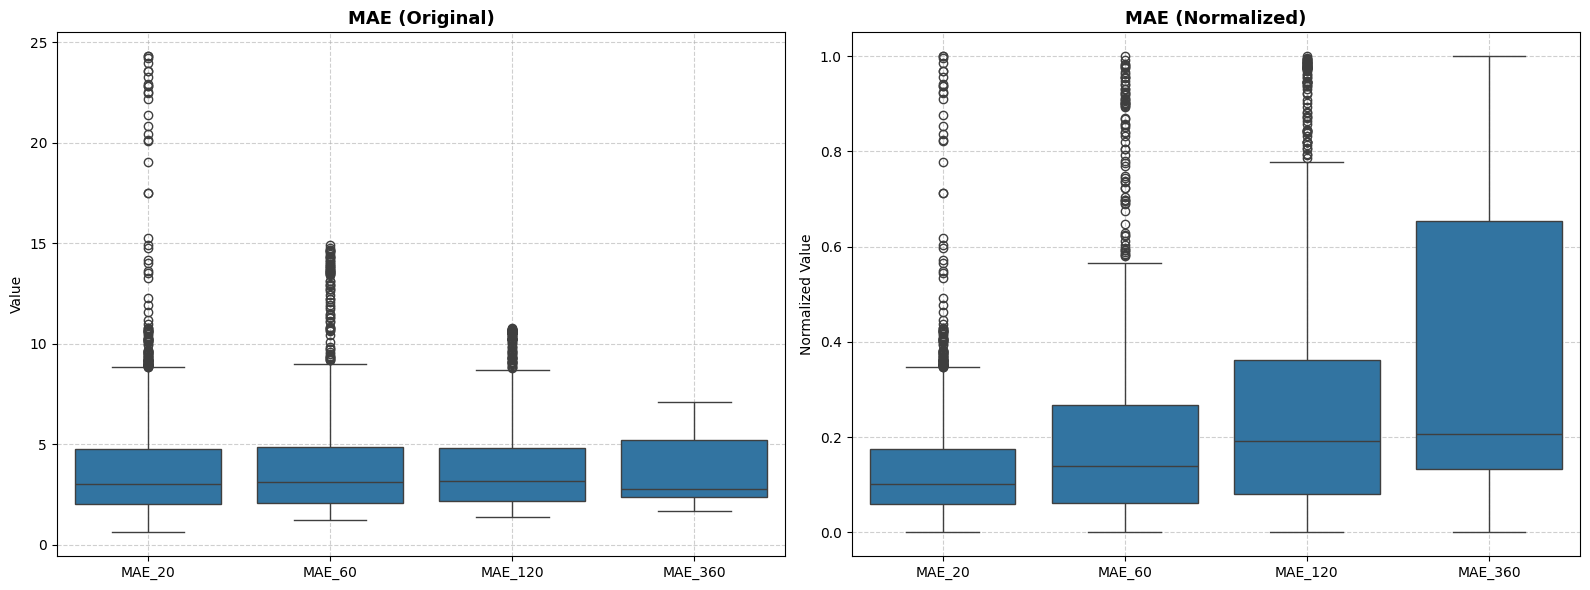

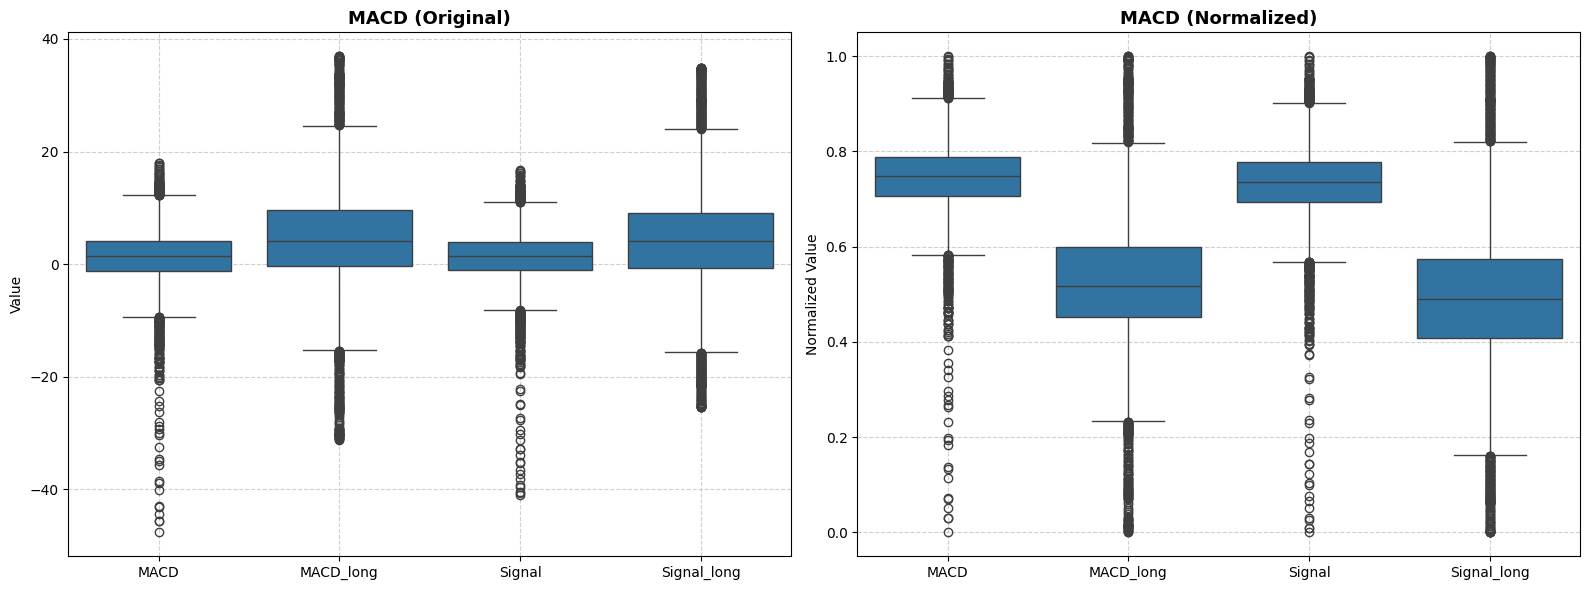

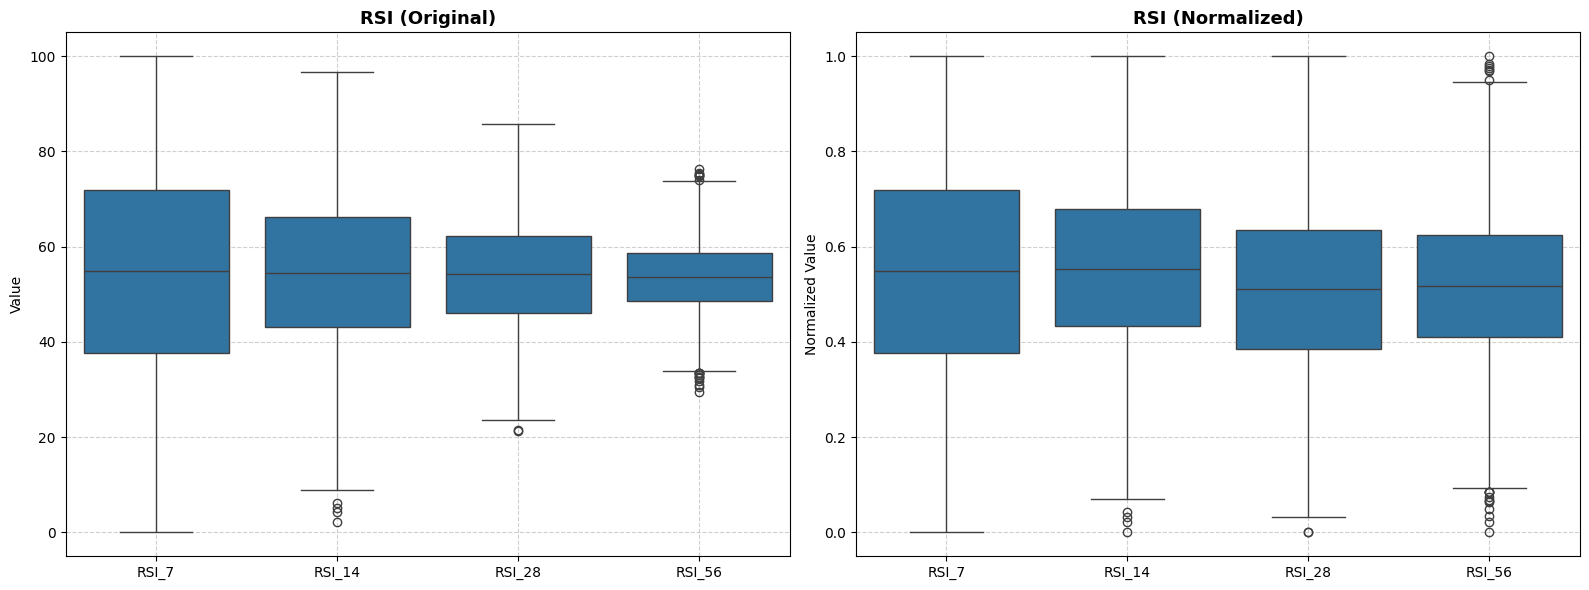

In [17]:
groups = {
    # "Volume": ["Volume"],
    "Index": ["Open", "High", "Low", "Close"],
    'Economics': [ 'VIX', 'DXY', 'CPI_US'],
    "MA & EMA": ['MA_20', 'EMA_20', 'MA_60', 'EMA_60', 'MA_120', 'EMA_120', 'MA_360', 'EMA_360'],
    "MAE": ['MAE_20', 'MAE_60', 'MAE_120', 'MAE_360',],
    "MACD": ['MACD', 'MACD_long', 'Signal', 'Signal_long'],
    "RSI": ['RSI_7', 'RSI_14', 'RSI_28', 'RSI_56']
}

for title, cols_in_group in groups.items():
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    data_melted = data.melt(
        value_vars=cols_in_group,
        var_name="Value Type",
        value_name="Value"
    )
    sns.boxplot(
        x="Value Type",
        y="Value",
        data=data_melted,
        order=cols_in_group,
        ax=axes[0]
    )
    axes[0].set_title(f"{title} (Original)", fontsize=13, fontweight='bold')
    axes[0].set_xlabel("")
    axes[0].set_ylabel("Value")
    axes[0].grid(True, linestyle="--", alpha=0.6)

    scaler = MinMaxScaler()
    data_norm = data[cols_in_group].copy()
    data_norm = pd.DataFrame(
        scaler.fit_transform(data_norm),
        columns=cols_in_group,
        index=data.index
    )
    data_norm_melted = data_norm.melt(
        value_vars=cols_in_group,
        var_name="Value Type",
        value_name="Value"
    )
    sns.boxplot(
        x="Value Type",
        y="Value",
        data=data_norm_melted,
        order=cols_in_group,
        ax=axes[1]
    )
    axes[1].set_title(f"{title} (Normalized)", fontsize=13, fontweight='bold')
    axes[1].set_xlabel("")
    axes[1].set_ylabel("Normalized Value")
    axes[1].grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    save_path = os.path.join(FIG_DIR, f"boxplot_{title.replace(' ', '_')}_compare.png")
    plt.savefig(save_path, dpi=150)
    plt.show()
    plt.close()

### c.3. Histogram

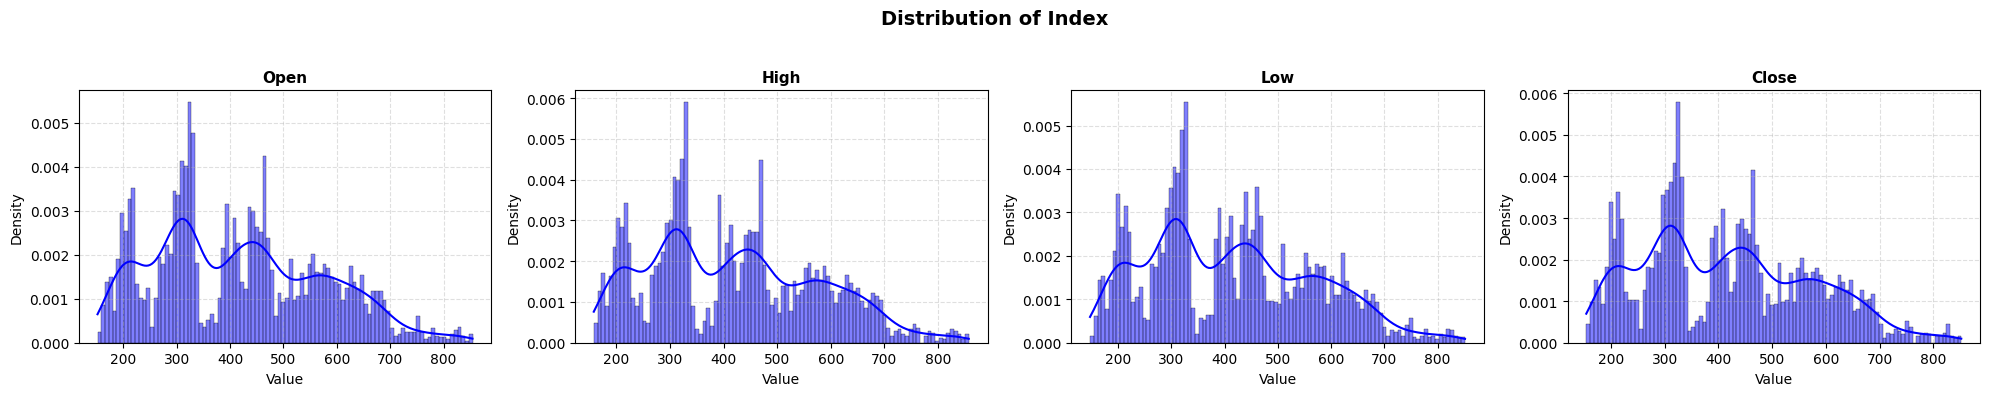

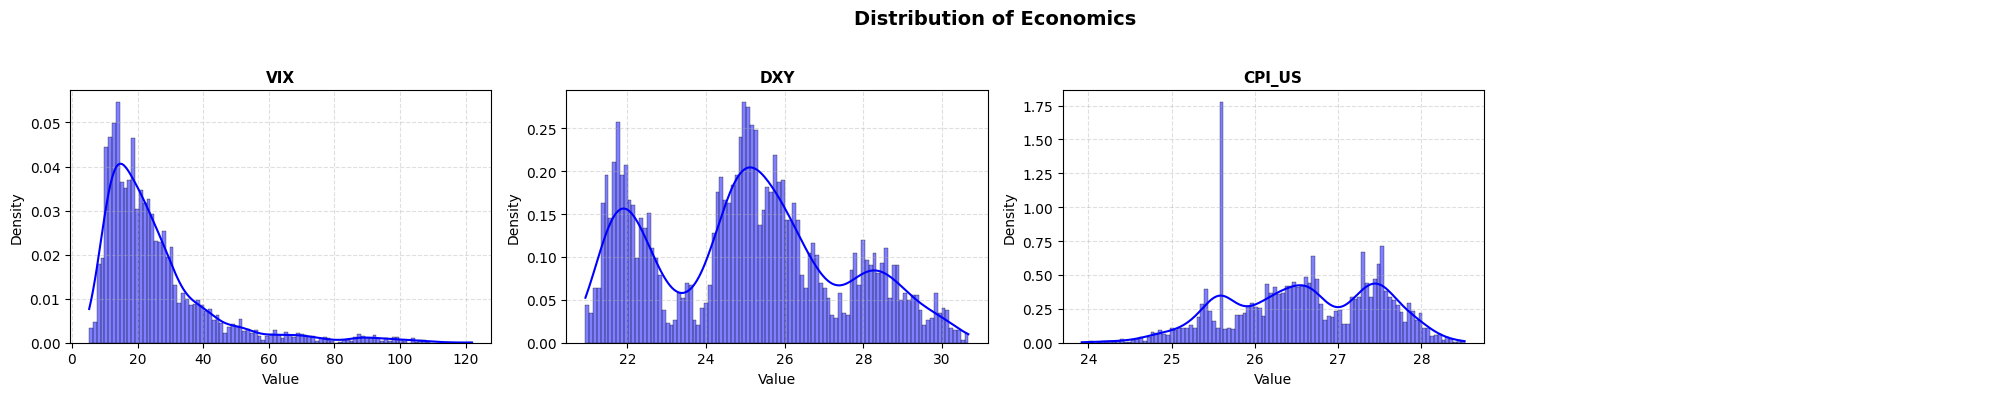

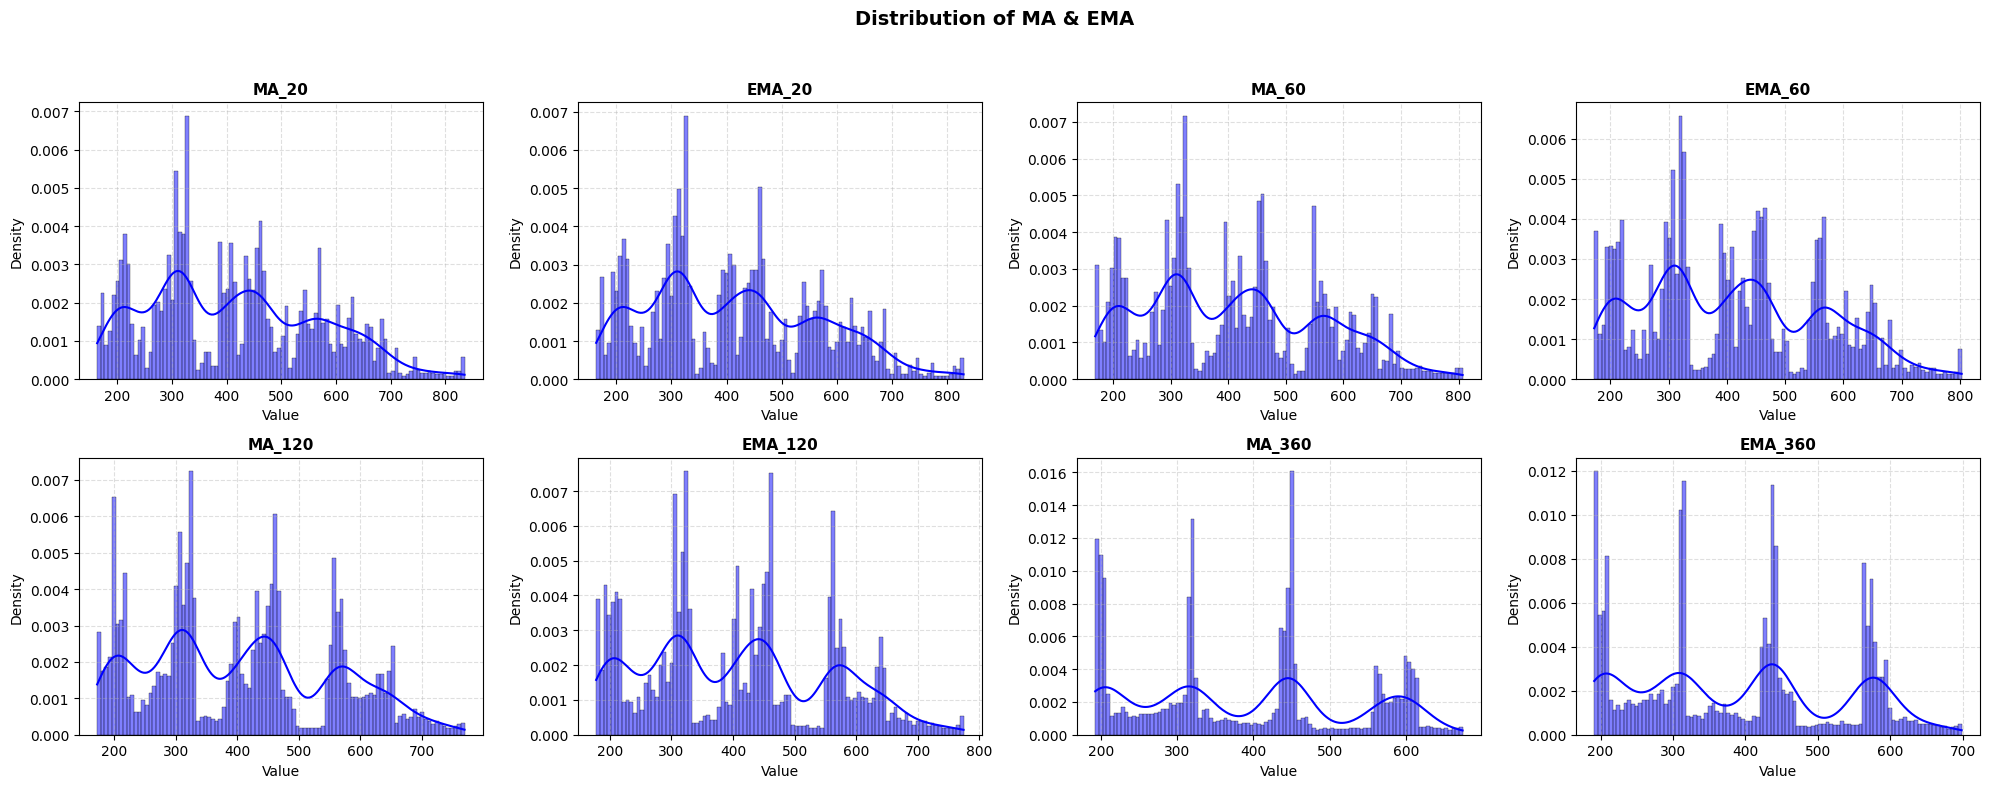

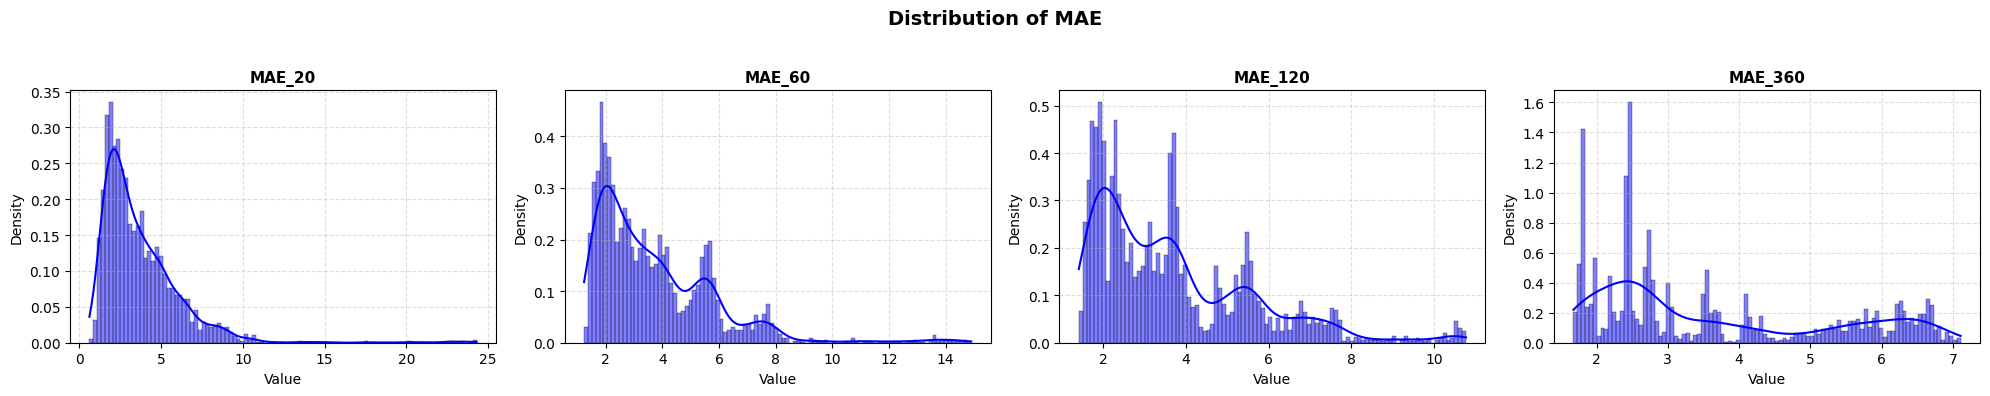

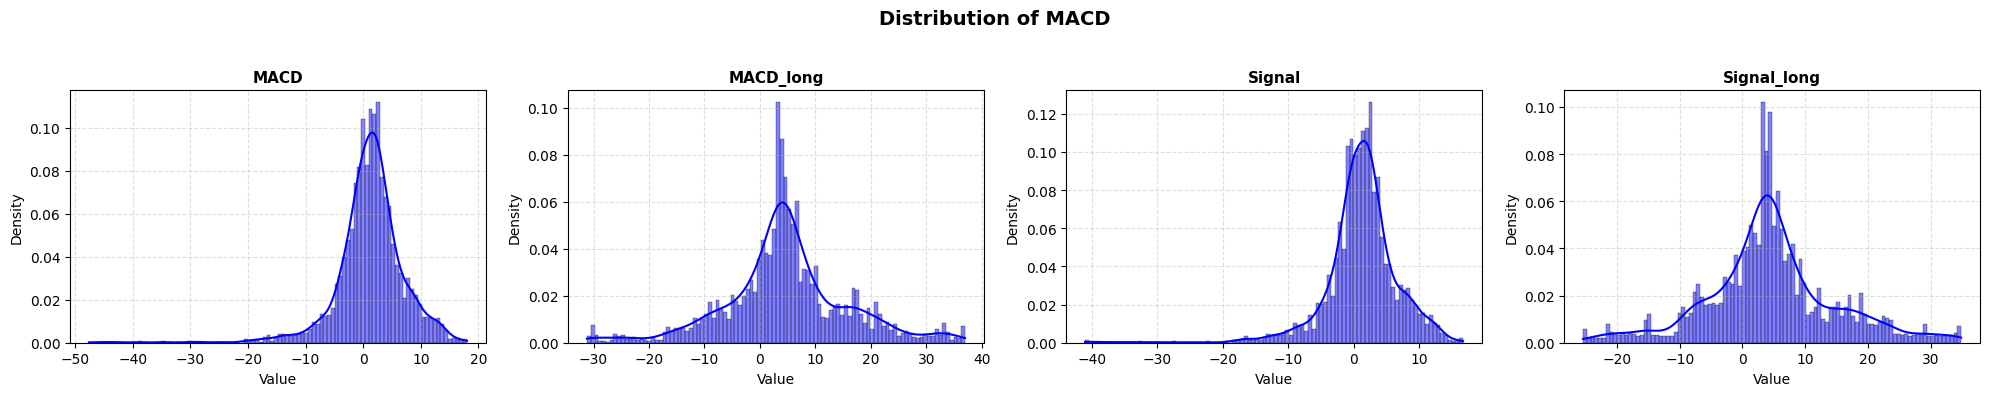

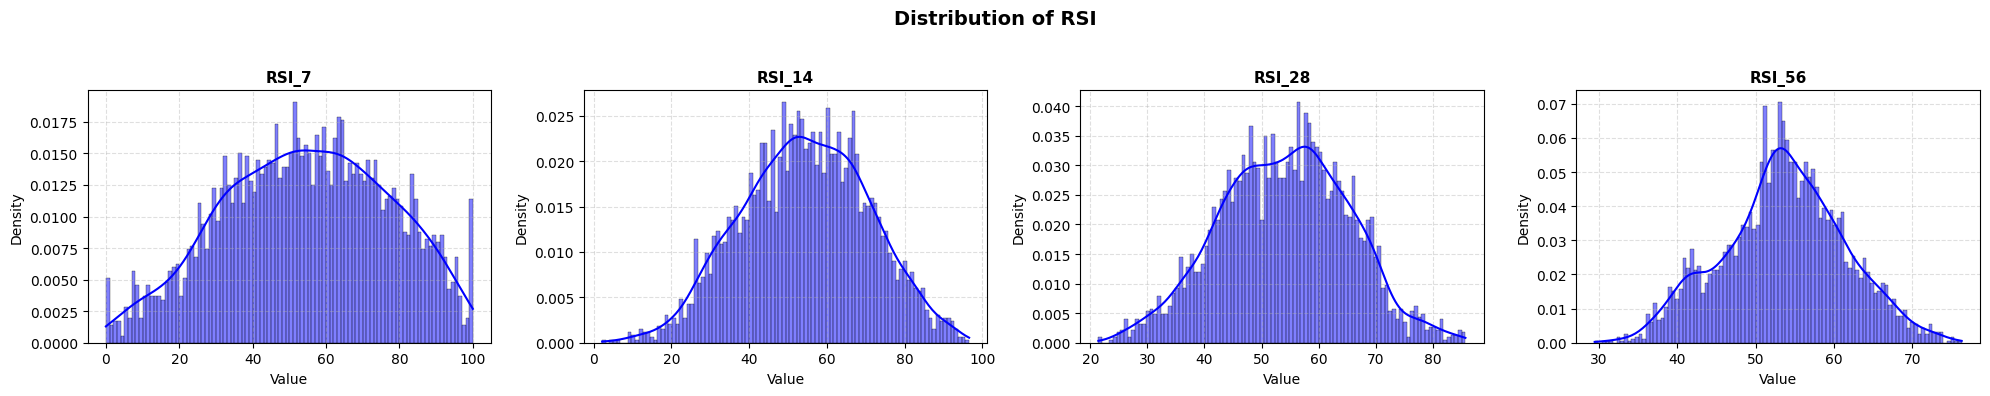

In [18]:
max_cols = 4

for title, cols_in_group in groups.items():
    n = len(cols_in_group)
    n_rows = math.ceil(n / max_cols)

    fig, axes = plt.subplots(n_rows, max_cols, figsize=(5*max_cols, 4*n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cols_in_group):
        sns.histplot(
            data[col].dropna(),
            kde=True,
            stat="density",
            bins=100,
            color="blue",
            ax=axes[i]
        )
        axes[i].set_title(f"{col}", fontsize=11, fontweight='bold')
        axes[i].set_xlabel("Value")
        axes[i].set_ylabel("Density")
        axes[i].grid(True, linestyle="--", alpha=0.4)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"Distribution of {title}", fontsize=14, fontweight='bold')
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    save_path = os.path.join(FIG_DIR, f"group_hist_{title.replace(' ', '_')}.png")
    plt.savefig(save_path, dpi=150)
    plt.show()
    plt.close()

### c.4. Line Chart

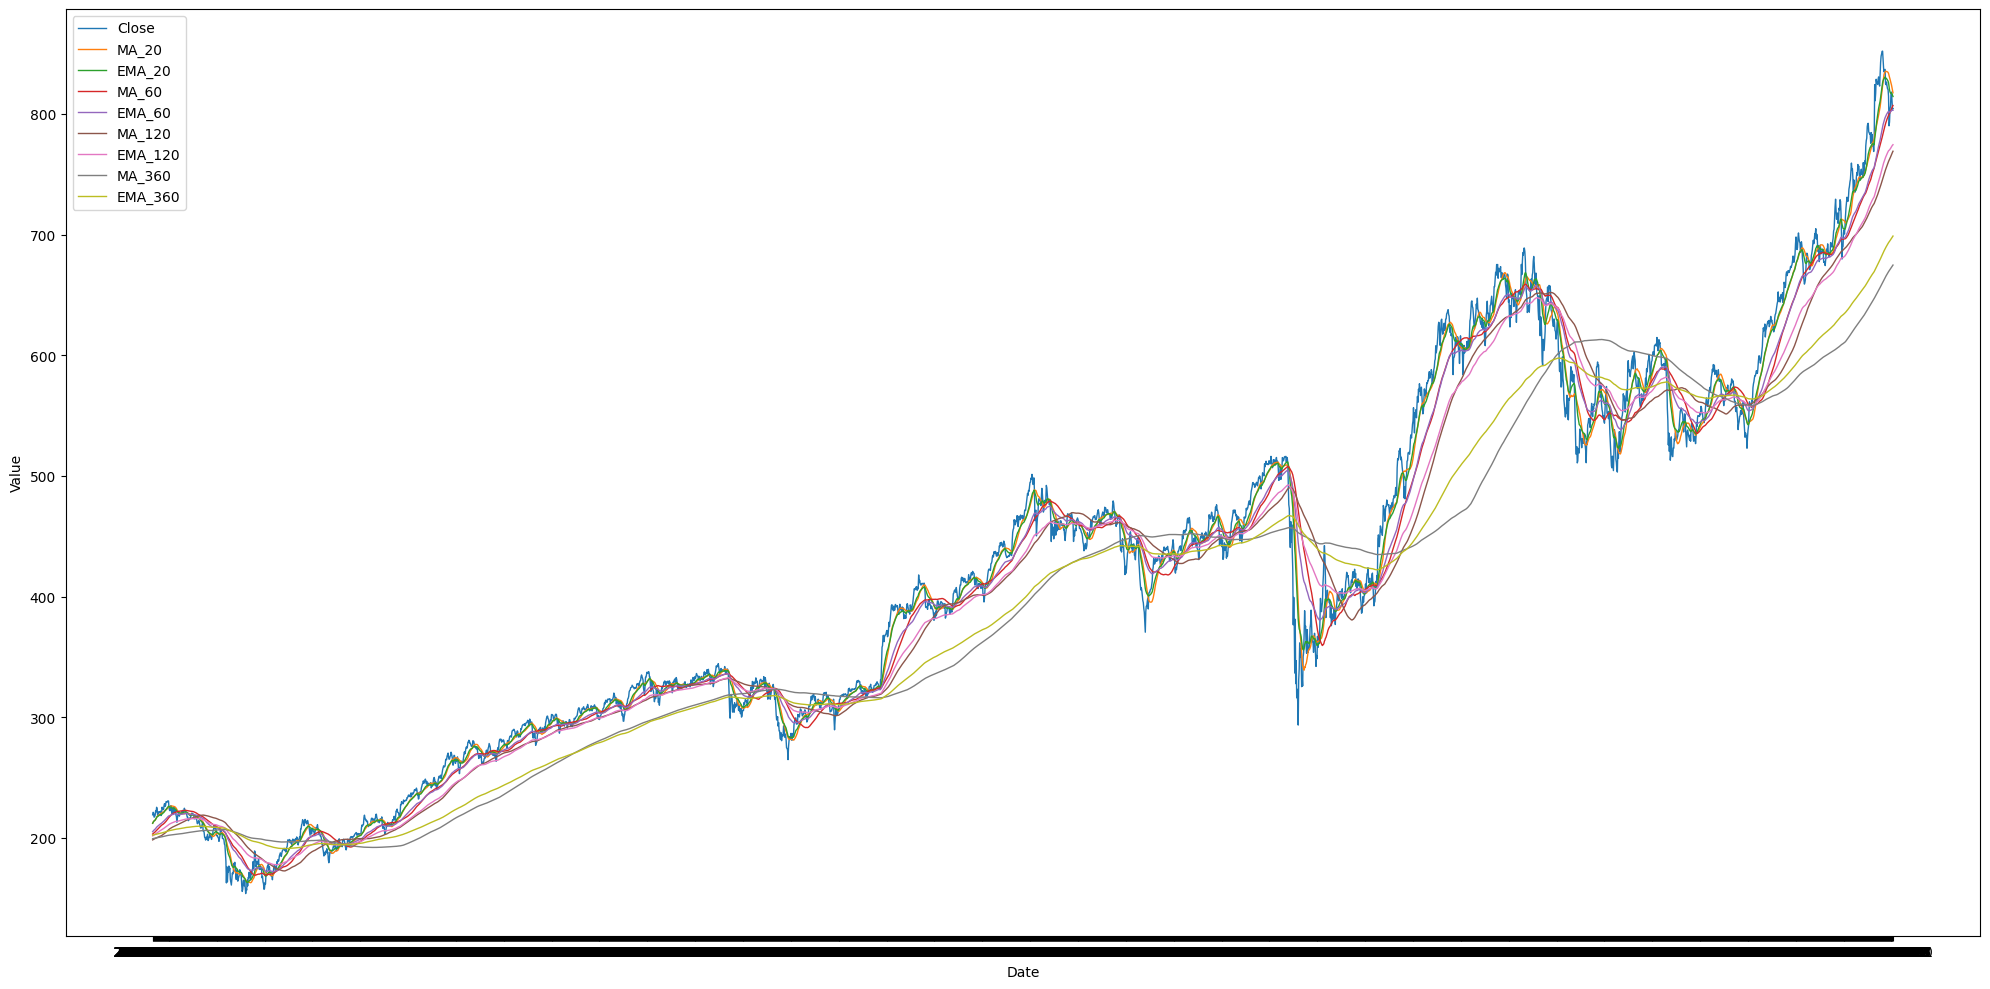

In [19]:
groups = {
    # 'Kinh te': ['DXY', 'CPI_US'],
    "MA & EMA": ["Close", 'MA_20', 'EMA_20', 'MA_60', 'EMA_60', 'MA_120', 'EMA_120', 'MA_360', 'EMA_360'],
    # "MAE": ['MAE_20', 'MAE_60', 'MAE_120', 'MAE_360',],
    # "MACD": ['MACD', 'MACD_long', 'Signal', 'Signal_long'],
    # "RSI": ['RSI', 'RSI_7', 'RSI_14', 'RSI_28']
}

plt.figure(figsize=(20,10))

for title, cols_in_group in groups.items():
    for col in cols_in_group:
        plt.plot(data["Date"], data[col], label=f"{col}", linewidth=1)

plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()
# line_path = os.path.join(FIG_DIR, "line_trend.png")
# plt.savefig(line_path, dpi=150)
plt.close()

### c.5. Heatmap

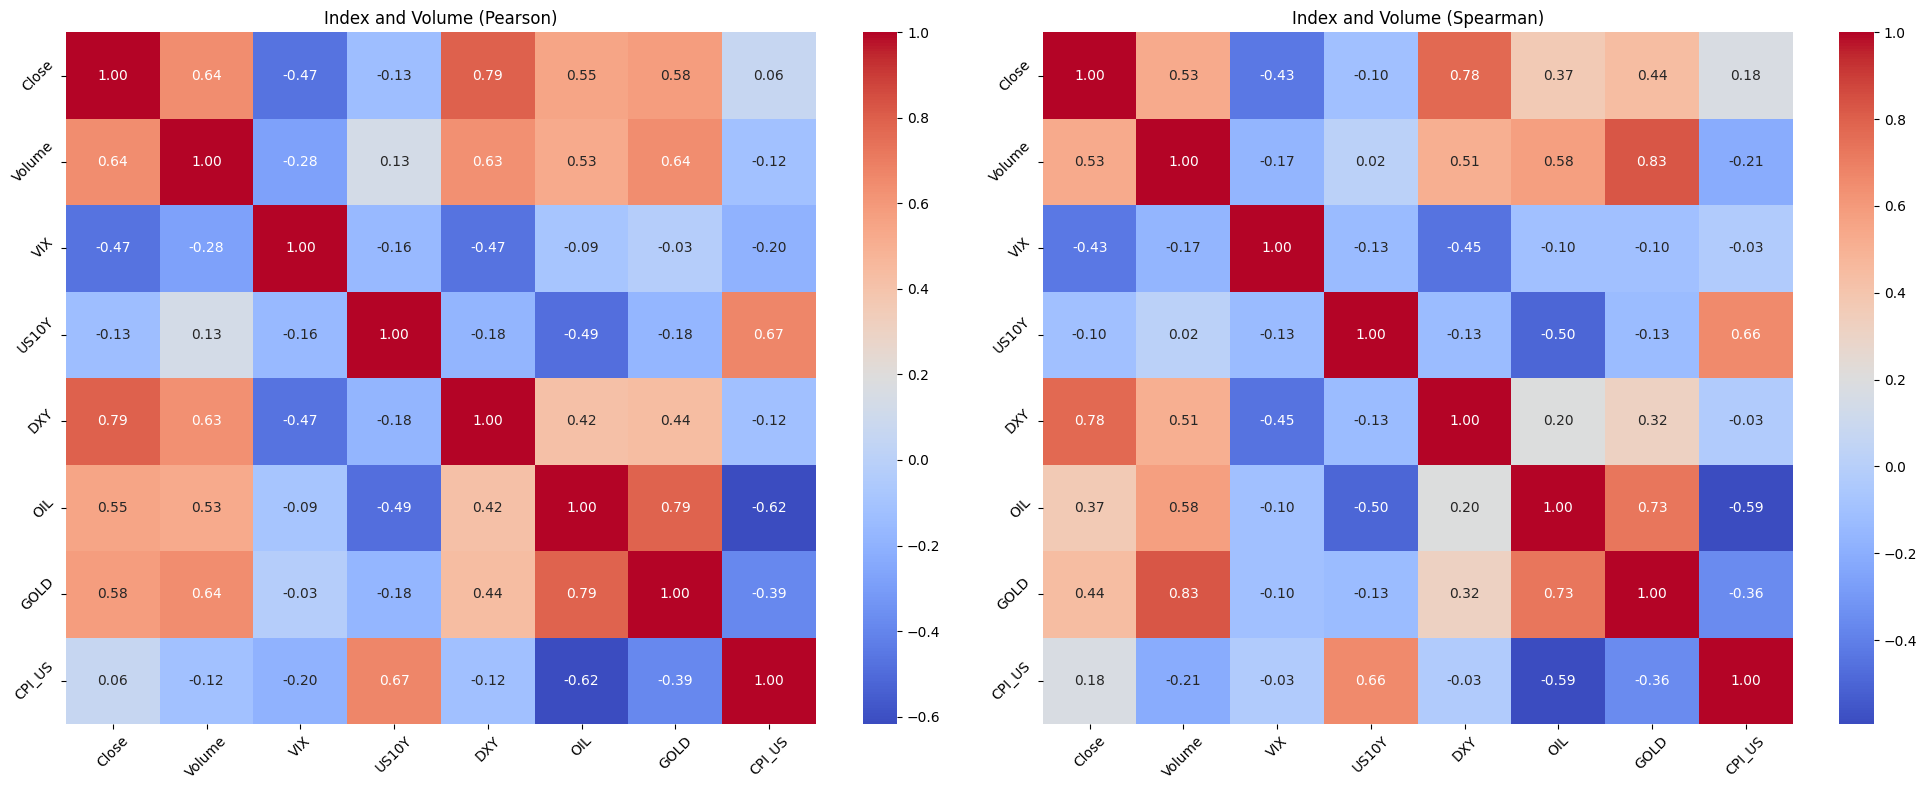

In [20]:
corr_pear = data[[
        'Close', 'Volume', 'VIX', 'US10Y', 'DXY', 'OIL', 'GOLD', "CPI_US"
    ]
].corr(method="pearson")

corr_spear = data[[
        'Close', 'Volume', 'VIX', 'US10Y', 'DXY', 'OIL', 'GOLD', "CPI_US"
    ]
].corr(method="spearman")

plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
sns.heatmap(corr_pear, annot=True, cmap="coolwarm", fmt=".2f")
plt.yticks(rotation=(45))
plt.xticks(rotation=(45))
plt.title("Index and Volume (Pearson)")

plt.subplot(1, 2, 2)
sns.heatmap(corr_spear, annot=True, cmap="coolwarm", fmt=".2f")
plt.yticks(rotation=(45))
plt.xticks(rotation=(45))
plt.title("Index and Volume (Spearman)")

plt.tight_layout()
plt.show()

## d. Anomaly detection

In [21]:
def detect_outliers_zscore(df, cols=None, z_thresh=3.0):
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    out = pd.DataFrame(False, index=df.index, columns=cols)
    for c in cols:
        vals = df[c].values
        z = np.abs(stats.zscore(vals, nan_policy='omit'))
        mask = np.zeros_like(z, dtype=bool)
        mask[~np.isnan(z)] = z[~np.isnan(z)] > z_thresh
        out[c] = mask
    return out

def detect_outliers_iqr(df, cols=None, k=1.5):
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    out = pd.DataFrame(False, index=df.index, columns=cols)
    for c in cols:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - k * iqr
        upper = q3 + k * iqr
        out[c] = (df[c] < lower) | (df[c] > upper)
    return out

In [22]:
def detect_outliers_rolling(df, col='Close', window=20, z_thresh=3.0, min_periods=None):
    if min_periods is None:
        min_periods = max(3, window//2)
    roll_mean = df[col].rolling(window=window, min_periods=min_periods, center=False).mean()
    roll_std  = df[col].rolling(window=window, min_periods=min_periods, center=False).std()
    z = (df[col] - roll_mean) / (roll_std + 1e-12)
    mask = z.abs() > z_thresh
    res = pd.Series(False, index=df.index, name=f'rolling_{col}')
    res[mask.fillna(False)] = True
    return res, roll_mean, roll_std

In [23]:
def detect_outliers_decompose(df, col='Close', model='additive', period=None, z_thresh=3.0):
    if period is None:
        period = 252 if df.shape[0] > 300 else None

    if period is None:
        raise ValueError("Need to pass period for seasonal_decompose with short window. E.g.: period=7,30,252 ...")

    decomp = seasonal_decompose(df[col].dropna(), model=model, period=period, extrapolate_trend='freq')
    resid = decomp.resid.reindex(df.index)  # align
    z = (resid - resid.mean()) / (resid.std(ddof=0) + 1e-12)
    mask = z.abs() > z_thresh
    return mask.fillna(False), decomp


## e. Dataset overall review

In [24]:
def detect_outliers_arima_residuals(df, col='Close', order=(1,1,1), z_thresh=3.0, enforce_stationarity=False, enforce_invertibility=False):
    series = df[col].dropna()
    try:
        model = ARIMA(series, order=order, enforce_stationarity=enforce_stationarity, enforce_invertibility=enforce_invertibility)
        res = model.fit()
        resid = res.resid.reindex(df.index)
        z = (resid - resid.mean()) / (resid.std(ddof=0) + 1e-12)
        mask = z.abs() > z_thresh
        return mask.fillna(False), res
    except Exception as e:
        print("ARIMA fitting failed:", e)
        return pd.Series(False, index=df.index), None


In [25]:
def detect_outliers_isolationforest(df, feature_cols=None, contamination=0.01, random_state=42):
    if feature_cols is None:
        feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    X = df[feature_cols].copy()
    X = X.fillna(method='ffill').fillna(method='bfill').fillna(0)
    sc = StandardScaler()
    Xs = sc.fit_transform(X)
    iso = IsolationForest(contamination=contamination, random_state=random_state)
    iso.fit(Xs)
    preds = iso.predict(Xs)
    mask = pd.Series(preds == -1, index=df.index)
    scores = pd.Series(iso.decision_function(Xs), index=df.index)
    return mask, scores


In [26]:
def aggregate_outliers(df, methods_dict):
    out_df = pd.DataFrame(index=df.index)
    for name, mask in methods_dict.items():
        out_df[name] = mask.astype(bool)
    out_df['any_outlier'] = out_df.any(axis=1)
    out_df['n_methods_flagged'] = out_df.drop(columns=['any_outlier']).sum(axis=1)
    return out_df


In [27]:
def plot_time_series_with_flags(df, col='Close', flags=None, title=None, figsize=(20,6)):
    plt.figure(figsize=figsize)
    plt.plot(df['Date'], df[col], label=col)
    if flags is not None:
        # flags: boolean Series indexed like df
        pts = df.loc[flags, col]
        plt.scatter(pts.index, pts.values, color='red', s=20, label='outlier')

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.title(title or f"{col} with outliers")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [28]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
zflags = detect_outliers_zscore(data, cols=numeric_cols, z_thresh=3.0)
iqrflags = detect_outliers_iqr(data, cols=numeric_cols, k=1.5)
roll_mask, roll_mean, roll_std = detect_outliers_rolling(data, col='Close', window=20, z_thresh=3.0)

try:
    decomp_mask, decomp = detect_outliers_decompose(data, col='Close', model='additive', period=252, z_thresh=3.0)
except ValueError:
    decomp_mask = pd.Series(False, index=data.index)

arima_mask, arima_res = detect_outliers_arima_residuals(data, col='Close', order=(1,1,1), z_thresh=3.5)

iso_mask, iso_scores = detect_outliers_isolationforest(data, feature_cols=numeric_cols, contamination=0.01)

methods_close = {
    'z_close': zflags['Close'],
    'iqr_close': iqrflags['Close'],
    'rolling_close': roll_mask,
    'decomp_close': decomp_mask,
    'arima_close': arima_mask,
    'iso_multivariate': iso_mask
}
agg_close = aggregate_outliers(data, methods_close)

methods_cols = {}
for c in numeric_cols:
    methods_cols[f'{c}_z'] = zflags[c]
    methods_cols[f'{c}_iqr'] = iqrflags[c]
agg_all = aggregate_outliers(data, methods_cols)

print("Top Close anomalies (any method):")
print(agg_close[agg_close['any_outlier']].sort_values('n_methods_flagged', ascending=False).head(20))


/tmp/ipykernel_721782/3125464411.py:5: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Top Close anomalies (any method):
      z_close  iqr_close  rolling_close  decomp_close  arima_close  \
2312    False      False          False          True         True   
2308    False      False          False          True         True   
2310    False      False          False          True         True   
3509    False      False          False         False         True   
3492    False      False          False          True        False   
3495    False      False          False          True        False   
3494    False      False          False          True        False   
3493    False      False          False          True        False   
2476    False      False           True         False         True   
3480    False      False           True         False         True   
2316    False      False          False          True         True   
2314    False      False          False          True        False   
3496    False      False          False          True   

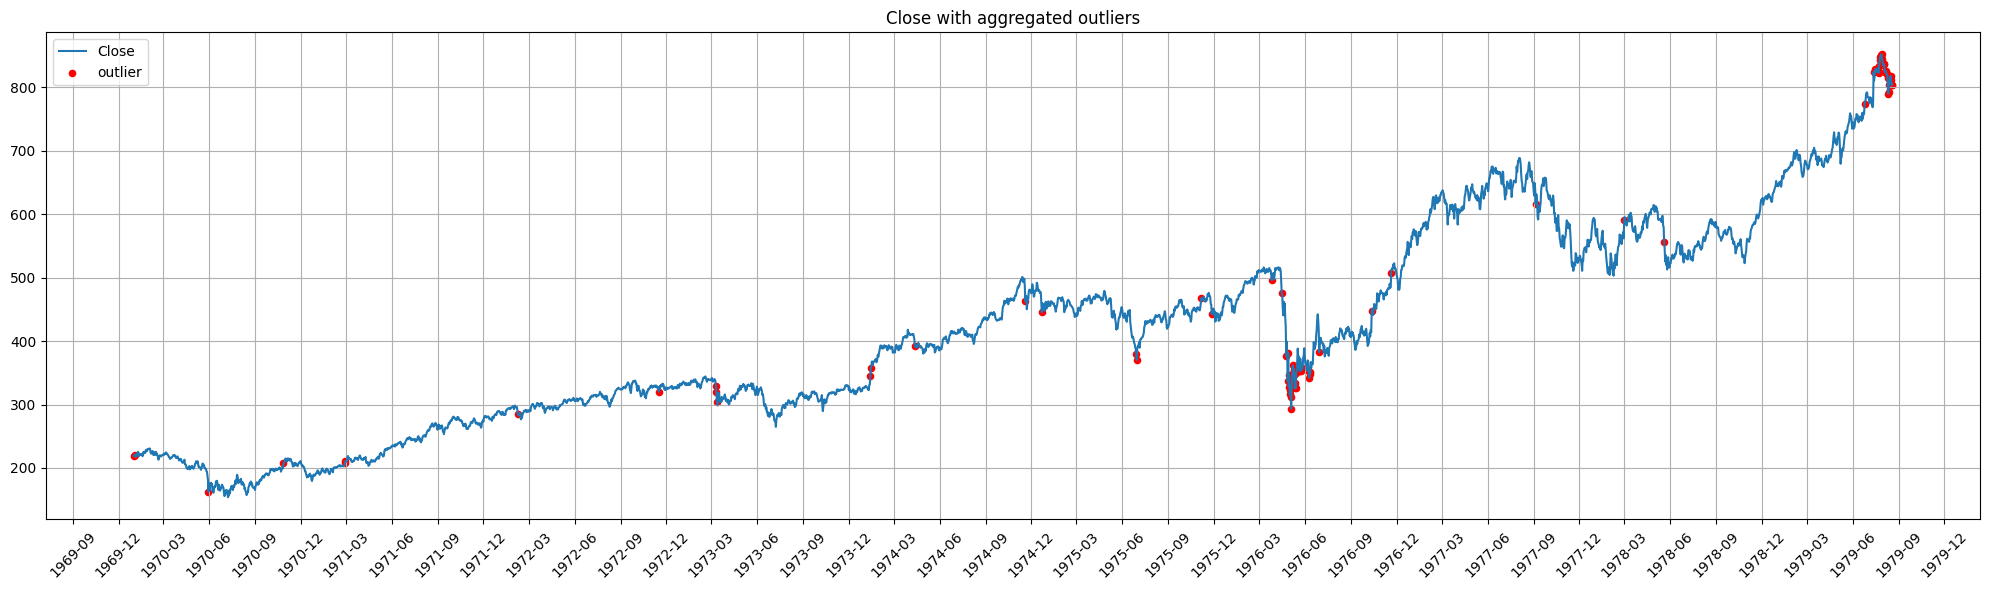

In [29]:
plot_time_series_with_flags(data, col='Close', flags=agg_close['any_outlier'], title="Close with aggregated outliers")

# **2. Probability distribution analysis**

# **3. Hypothesis Testing**

# **4. Correlation Analysis**

# **5. Multiple Linear Regression**